In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as hc
from scipy.spatial import distance_matrix

sns.set()

## Load data

We load data. We have two `DataFrame`s: `full_df1` and `full_df2`, corresponding respectively to all the results of the first and second rounds of elections.

In [2]:
with open('../data/presidentielle.pkl', 'rb') as f:
    data = pickle.load(f)

df1 = data['df1']
df2 = data['df2']
colnames = data['colnames']

## Data description

Each row represents a voting station which is identified by its location and the number of registered voters.

In [3]:
df1[colnames['id']].head()

,CodeDepartement,NomDepartement,CodeCirconscription,NomCirconscription,CodeCommune,NomCommune,CodeBureauVote,Inscrits
0,01,Ain,4,4ème circonscription,1,L'Abergement-Clémenciat,0001,645
1,01,Ain,5,5ème circonscription,2,L'Abergement-de-Varey,0001,213
2,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0001,1129
3,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0002,1128
4,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0003,1213


We get the corresponding number of votes for each candidate. `No_One` corresponds to blank, invalid ballots and not casting a ballot (abstention). 

In [4]:
df1[colnames['choices1']].head()

,No_One,Arthaud,Roussel,Macron,Lassalle,Le_Pen,Zemmour,Melenchon,Hidalgo,Jadot,Pecresse,Poutou,Dupont_Aignan
0,125,3,6,150,18,149,43,66,5,30,26,3,21
1,42,2,7,50,10,23,14,41,3,10,8,3,0
2,289,4,30,159,24,237,69,216,15,25,40,8,13
3,286,6,13,201,19,210,68,194,19,46,42,4,20
4,264,8,18,229,28,227,74,227,16,65,35,3,19


In [5]:
df2[colnames['choices2']].head()

,No_One,Macron,Le_Pen
0,193,237,213
1,71,94,48
2,415,360,355
3,376,426,327
4,411,449,353


We look at the number of registered voters and voting stations by the department. 

We note that departments with a number corresponding to metropolitan France. Departments starting with 'Z' correspond to are located outside of France ('ZZ').

In [6]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print((df1.groupby(["CodeDepartement", "NomDepartement"]).
    Inscrits.
    agg(["count", "sum"]).
    rename(columns={"count": "N_Stations",
                    "sum": "N_Voters"})))

                                                 N_Stations  N_Voters
CodeDepartement NomDepartement                                       
01              Ain                                     575    434374
02              Aisne                                   905    364443
03              Allier                                  448    248763
04              Alpes-de-Haute-Provence                 241    126898
05              Hautes-Alpes                            193    112859
06              Alpes-Maritimes                         954    761331
07              Ardèche                                 413    250810
08              Ardennes                                484    181636
09              Ariège                                  285    113381
10              Aube                                    486    200913
11              Aude                                    479    273584
12              Aveyron                                 433    219124
13              Bouc

In [7]:
df1

,CodeDepartement,NomDepartement,CodeCirconscription,NomCirconscription,CodeCommune,NomCommune,CodeBureauVote,Inscrits,Abstentions,Votants,...,Macron,Lassalle,Le_Pen,Zemmour,Melenchon,Hidalgo,Jadot,Pecresse,Poutou,Dupont_Aignan
0,01,Ain,4,4ème circonscription,1,L'Abergement-Clémenciat,0001,645,108,537,...,150,18,149,43,66,5,30,26,3,21
1,01,Ain,5,5ème circonscription,2,L'Abergement-de-Varey,0001,213,38,175,...,50,10,23,14,41,3,10,8,3,0
2,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0001,1129,266,863,...,159,24,237,69,216,15,25,40,8,13
3,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0002,1128,265,863,...,201,19,210,68,194,19,46,42,4,20
4,01,Ain,5,5ème circonscription,4,Ambérieu-en-Bugey,0003,1213,246,967,...,229,28,227,74,227,16,65,35,3,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64140,ZZ,Français établis hors de France,3,3ème circonscription,177,Riga,0001,264,89,175,...,49,5,21,25,40,5,18,10,0,0
64141,ZZ,Français établis hors de France,11,11ème circonscription,195,Singapour,0001,8934,3531,5403,...,3226,57,143,586,505,54,370,337,16,44
64142,ZZ,Français établis hors de France,3,3ème circonscription,203,Tallinn,0001,362,136,226,...,89,4,8,37,42,13,15,4,2,6
64143,ZZ,Français établis hors de France,11,11ème circonscription,212,Tokyo,0001,5864,2684,3180,...,1117,41,81,422,900,87,248,136,15,63


We have several voting stations that have no registered voters or did not cast a single valid vote for a candidate. We will remove these stations from further analysis.

In [8]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df1.query('Inscrits == No_One')[["NomCommune",
                                              "Inscrits", "Votants",
                                              "No_One", "Abstentions"]])

Empty DataFrame
Columns: [NomCommune, Inscrits, Votants, No_One, Abstentions]
Index: []


We see that there are four main choices in the first round: No Candidate, Macron, Le Pen, and Mélenchon. People polarized around these three candidates. Not many people went to the voting booth to cast a blank or invalid ballot.

In [9]:
(df1[colnames['choices1']].sum(axis=0) / df1["Inscrits"].sum(axis=0)).sort_values(ascending=False)

No_One           0.252449
Macron           0.208924
Le_Pen           0.176114
Melenchon        0.157686
Zemmour          0.053533
Pecresse         0.036204
Jadot            0.035025
Lassalle         0.023970
Roussel          0.017504
Dupont_Aignan    0.015575
Hidalgo          0.013114
Poutou           0.005745
Arthaud          0.004158
dtype: float64

Le Pen voters didn't seem to do more numerous than people that didn't choose anyone. 

In [10]:
(df2[colnames['choices2']].sum(axis=0) / df2["Inscrits"].sum(axis=0)).sort_values(ascending=False)

Macron    0.396796
No_One    0.320089
Le_Pen    0.283115
dtype: float64

## Format data

We only keep voting stations with at least 30 valid votes in both elections. We will compute the relative proportion of each candidate for these voting stations. We do this in `./scripts/prepare_data.py` and retrieve data here.

In [11]:
# filter
df1 = data['df1']
df2 = data['df2']

# compute proportions
prop1 = data['prop1']
prop2 = data['prop2']

prop1.head(3)

,No_One,Arthaud,Roussel,Macron,Lassalle,Le_Pen,Zemmour,Melenchon,Hidalgo,Jadot,Pecresse,Poutou,Dupont_Aignan
0,0.193798,0.004651,0.009302,0.232558,0.027907,0.231008,0.066667,0.102326,0.007752,0.046512,0.040310,0.004651,0.032558
1,0.197183,0.009390,0.032864,0.234742,0.046948,0.107981,0.065728,0.192488,0.014085,0.046948,0.037559,0.014085,0.000000
2,0.255979,0.003543,0.026572,0.140833,0.021258,0.209920,0.061116,0.191320,0.013286,0.022143,0.035430,0.007086,0.011515


## PCA

We run PCA on first-round results. We plot the first two principal components and color points (voting booths) with proportional results for each candidate.

We find four "poles" that seem to be defined by the four main choices: Macron, Le Pen, Mélenchon, and Abstention. Pécresse voters seem to cluster with Macron voters and Jadot voters seem to be in between Mélenchon and Macron.

In [17]:
pca1 = PCA(n_components=2)
pca1.fit(prop1.apply(lambda x: (x - x.mean()) / x.std(), axis=0))
pca_df1 = pca1.transform(prop1)
pca_df1 = pd.DataFrame(pca_df1)
pca_df1.columns = ["PC" + str(x+1) for x in range(pca_df1.shape[1])]
pca_df1 = pd.concat([prop1, pca_df1], axis=1)

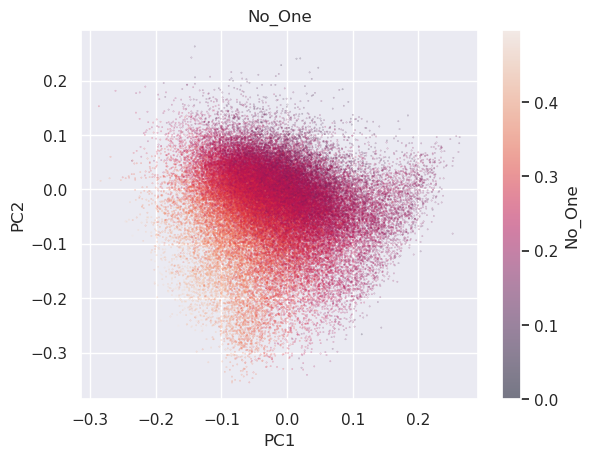

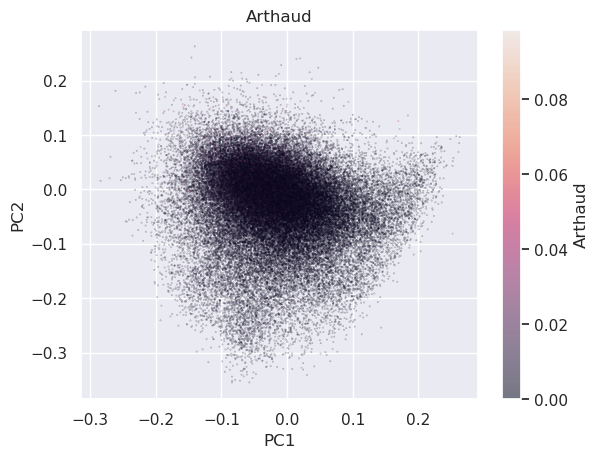

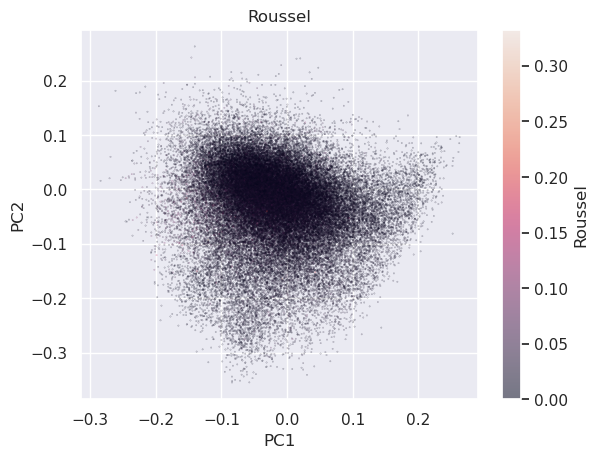

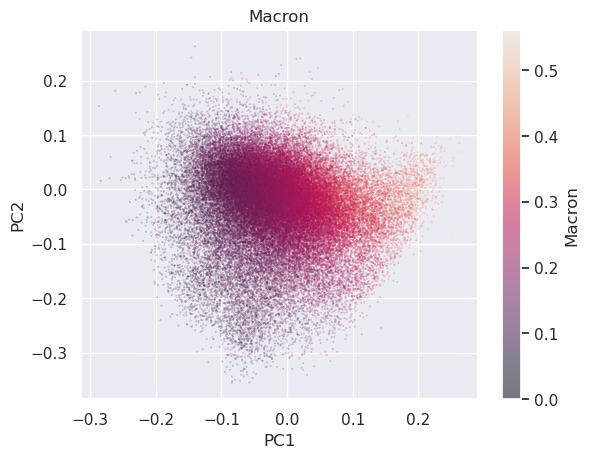

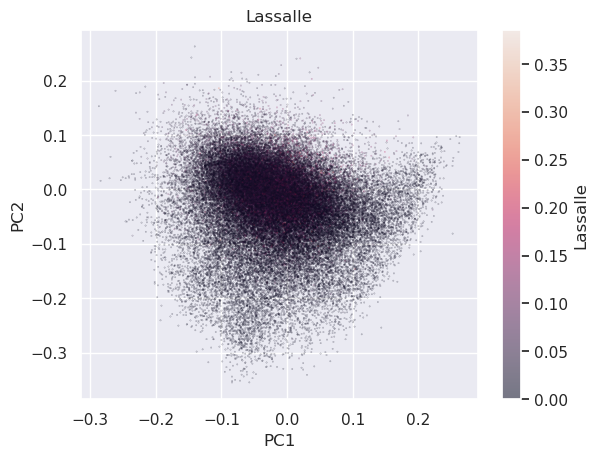

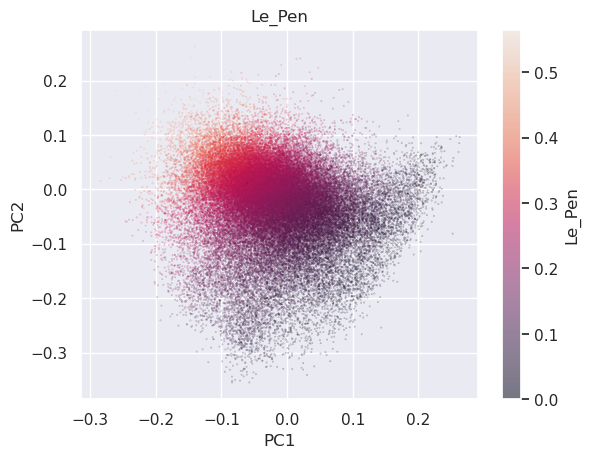

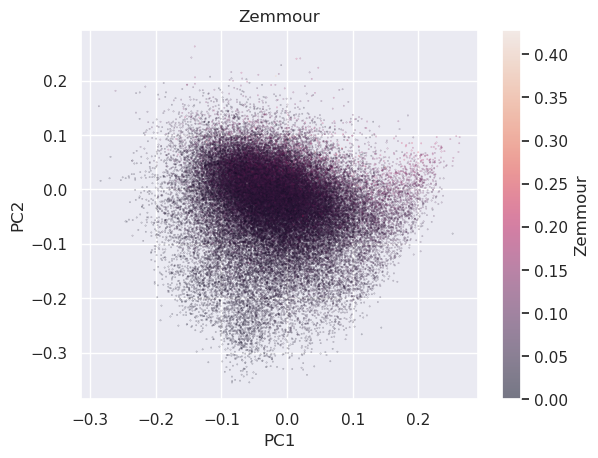

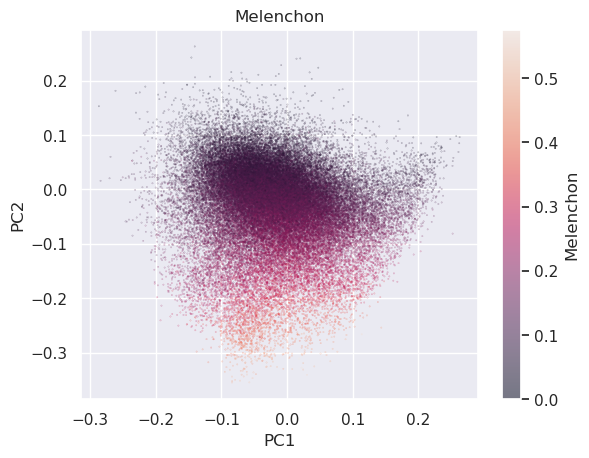

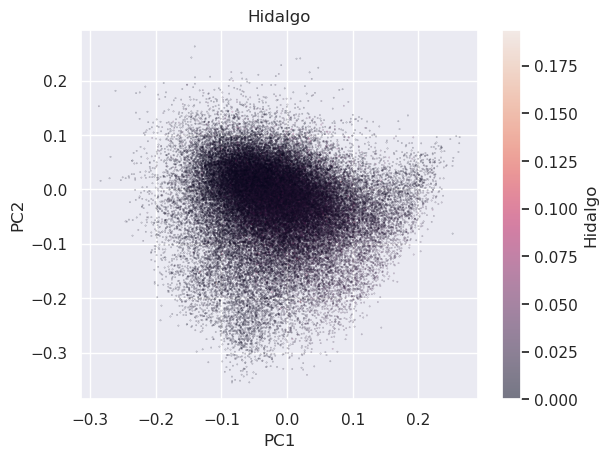

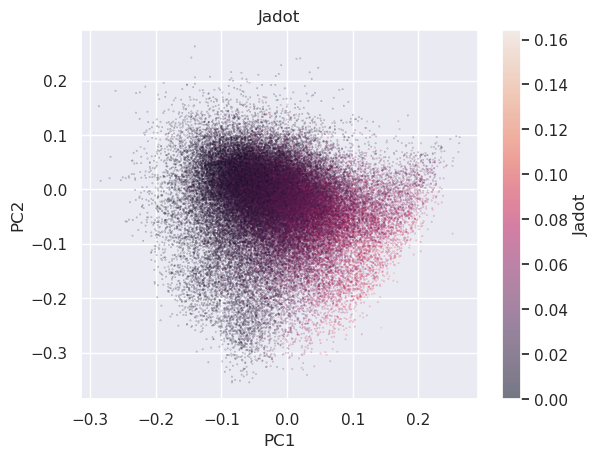

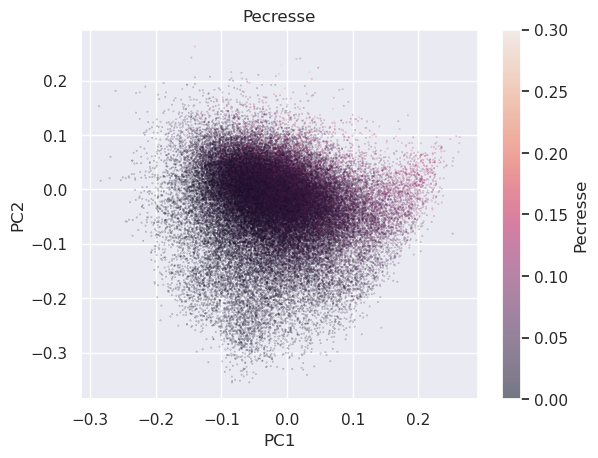

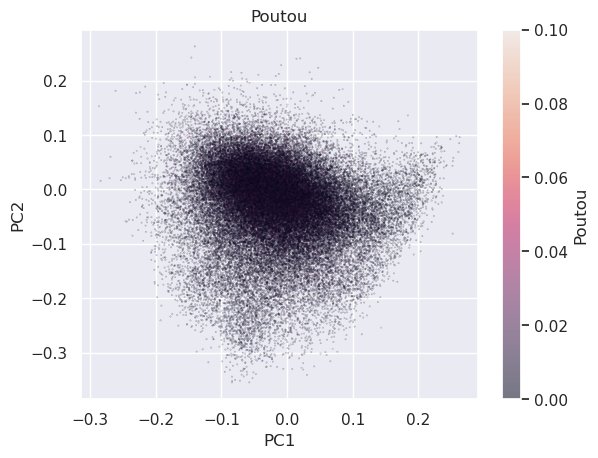

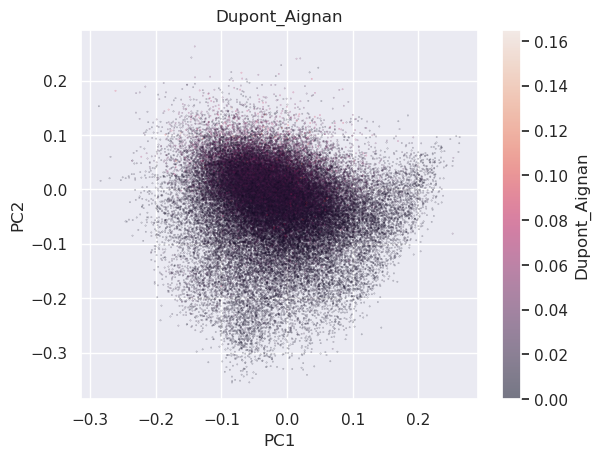

In [18]:
for candicat in colnames['choices1']: 
    pca_df1.plot.scatter("PC1", "PC2", s=.05, c=candicat, alpha=.5)
    plt.title(candicat)

We repeat the same analysis in the second round. We find the same poles (except Mélenchon who did not pass to the second round).

In [14]:
pca2 = PCA(n_components=2)
pca2.fit(prop2.apply(lambda x: (x - x.mean()) / x.std(), axis=0))
pca_df2 = pca2.transform(prop2)
pca_df2 = pd.DataFrame(pca_df2)
pca_df2.columns = ["PC" + str(x+1) for x in range(pca_df2.shape[1])]
pca_df2 = pd.concat([prop2, pca_df2], axis=1)

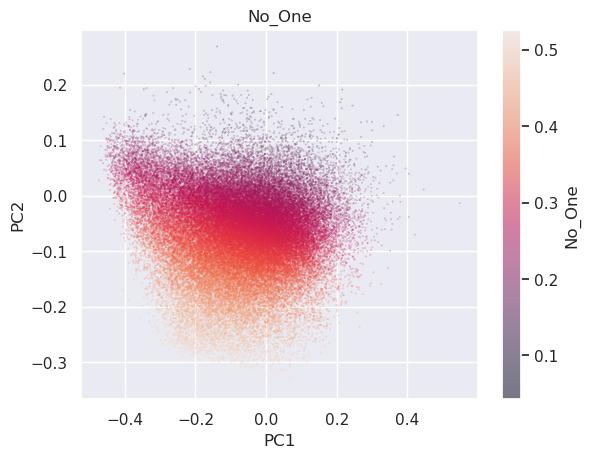

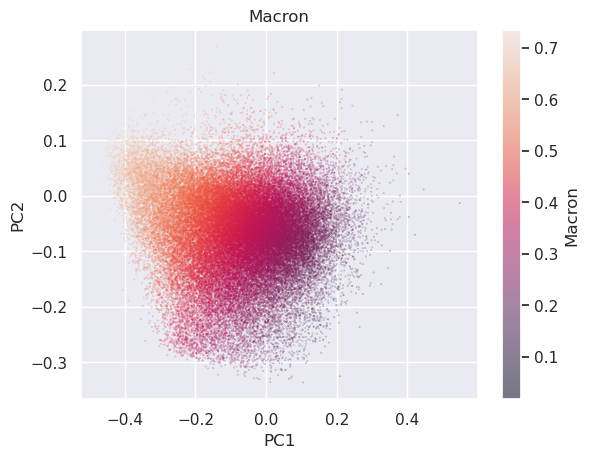

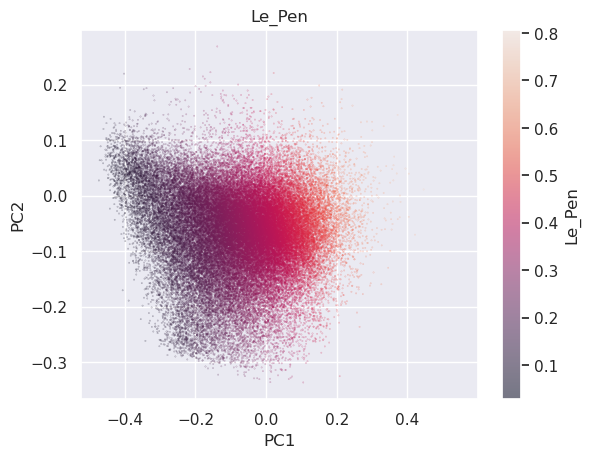

In [15]:
for candicat in colnames['choices2']: 
    pca_df2.plot.scatter("PC1", "PC2", s=.05, c=candicat, alpha=.5)
    plt.title(candicat)

## Hierarchical Clustering using Correlation Matrix

This suggests three clusters:

- Cluster 1: Mélenchon and other left-wing candidates.
- Cluster 2: Macron, Jadot, Zémmour, Pécresse
- Cluster 3: Le Pen, Lassalle, Dupont-Aignat

Overall the cohesion of these clusters is quite low.

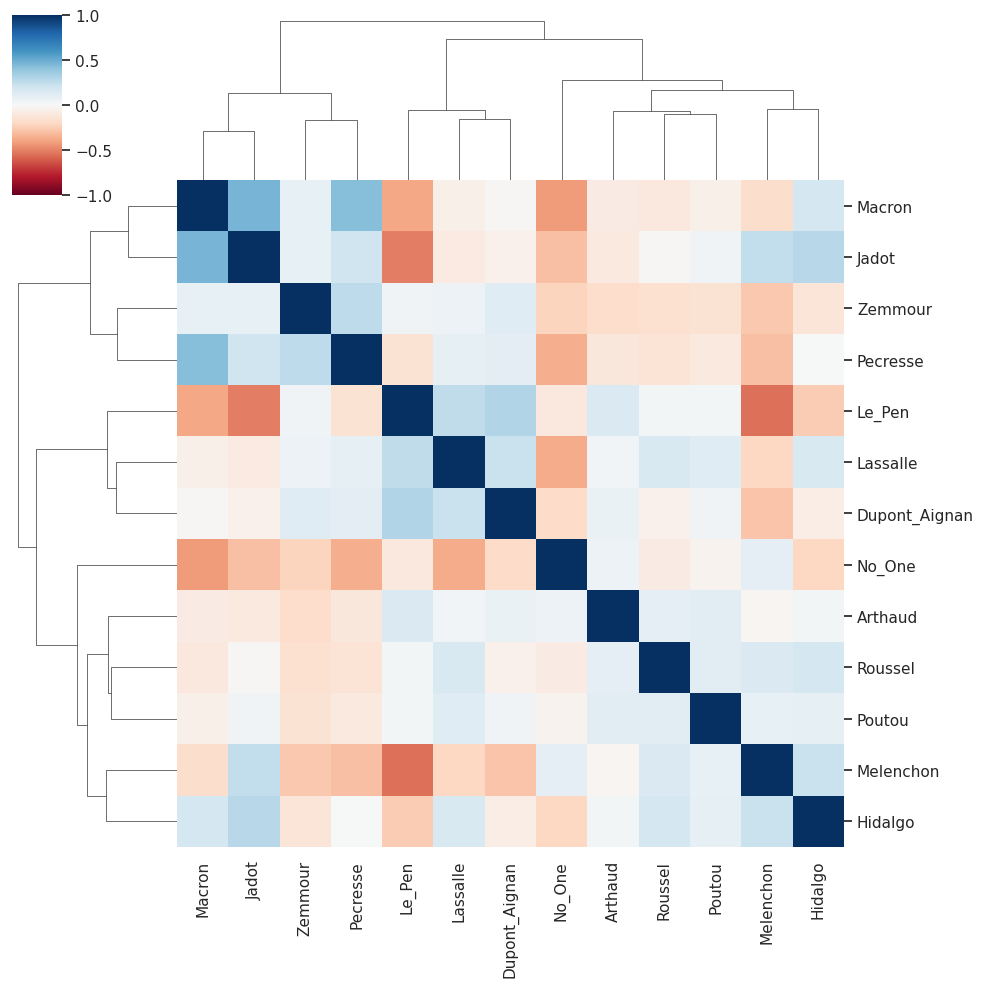

In [16]:
corr_prop1 = prop1.corr('spearman')

corr_prop1 = pd.DataFrame(corr_prop1)
corr_prop1.index = prop1.columns
corr_prop1.columns = prop1.columns

linkage = hc.linkage(hc.distance.pdist(corr_prop1), method='ward')
sns.clustermap(corr_prop1, cmap="RdBu", row_linkage=linkage, col_linkage=linkage, vmin=-1)